# 1. Loading the Data Set

This code will run for 1 or 2 minutes

In [ ]:

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'face-recognition-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F959963%2F1624149%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240329%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240329T154100Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D09c326b1cbd80fdad92aac2abce73a428cbcea742e2469675072966bd1520ef1171bb1f4cce54d4423790affea76cff4b4b0004858df96a207bed370b670f887a75d925f74fb6dc6b1ebd496bceb442cf6d57db8f59e0bc9f3fc46d820d10ffe34fe01691327fe98929a20b91130003301a883b412127688c433c8280eb638dadcf4ac3e00d340e0cb462320863b22712142096e7ddaaeec2623464777a973bde892e45950faa8bcc20b79411ba9aa545daf9b66ad5c5133201b643a746d3d49c269d5a7b085ce11bf4788163ca1bae6de2122ed317da8294d2e2dc857f4d747bce10905bd834d34cf217749a7b67795b3474353c0d60fa7805241124b6e986c'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')

[==================================================] 761024670 bytes downloaded
Downloaded and uncompressed: face-recognition-dataset
Data source import complete.


# 2. Importing Libraries

In [ ]:
import numpy as np
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import torch
from torchvision import datasets, transforms
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import SGD

# 3. Cleaning Data Set

In [ ]:
### We can change these features depending the model
## batch size is the number of images by batch
## h_size and l_size specifies the dimensions to which all images will be resized.
batch_size = 32
h_size = 224
l_size = 224

dir="../input/face-recognition-dataset/Original Images/Original Images/"

I Loaded the data set in tensor version and torch version

## Tensor Version


In [ ]:
generator = ImageDataGenerator()
data_set_tensor = generator.flow_from_directory(dir,target_size=(h_size, l_size),batch_size=batch_size)
classes = list(data_set_tensor.class_indices.keys())

Found 2562 images belonging to 31 classes.


In [ ]:
len(data_set_tensor)

81

### Torch Version

In [ ]:

# Define transformations to apply to the images
data_transforms = transforms.Compose([
    transforms.Resize((h_size, l_size)),
    transforms.ToTensor()
])

data_set_torch = datasets.ImageFolder(dir, transform=data_transforms)
dataloader_torch = torch.utils.data.DataLoader(data_set_torch, batch_size=batch_size, shuffle=True)
classes = data_set_torch.classes

The way that this data set is organized is through folders of images (31 folders). Classes come from the names of the folders. In the demo code the way that they prove the algorithm is calling one image from one of these folders and predict it. The example of the code is below:

## Resnet

In [ ]:
# ResNet
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization
import numpy as np
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout
import matplotlib.pyplot as plt
from tensorflow.keras.layers  import BatchNormalization
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

classes = list(data_set_tensor.class_indices.keys())
base_model  = ResNet50(include_top=False, input_shape=(224, 224, 3), pooling='avg')
model_resnet = Sequential([
    base_model,
    Flatten(),
    Dense(1024, activation = "relu"),
    Dropout(0.2),
    Dense(len(classes), activation = "softmax")
])


94765736/94765736 [==============================] - 0s 0us/step


In [ ]:
base_model.trainable = False

In [ ]:
model_resnet.compile(
    loss= "categorical_crossentropy",
    optimizer = Adam(),
    metrics = ["accuracy"]
)
model_resnet.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 31)                31775     
                                                                 
Total params: 25717663 (98.11 MB)
Trainable params: 2129951 (8.13 MB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


In [ ]:
history_ResNet = model_resnet.fit(data_set_tensor,epochs= 20, batch_size=32)

Epoch 1/20
81/81 [==============================] - 491s 6s/step - loss: 2.9217 - accuracy: 0.2104
Epoch 2/20
81/81 [==============================] - 490s 6s/step - loss: 1.7885 - accuracy: 0.4500
Epoch 3/20
81/81 [==============================] - 488s 6s/step - loss: 1.3200 - accuracy: 0.5808
Epoch 4/20
81/81 [==============================] - 489s 6s/step - loss: 1.0416 - accuracy: 0.6749
Epoch 5/20
81/81 [==============================] - 490s 6s/step - loss: 0.7984 - accuracy: 0.7533
Epoch 6/20
81/81 [==============================] - 486s 6s/step - loss: 0.6413 - accuracy: 0.8033
Epoch 7/20
81/81 [==============================] - 488s 6s/step - loss: 0.5035 - accuracy: 0.8536
Epoch 8/20
81/81 [==============================] - 478s 6s/step - loss: 0.3887 - accuracy: 0.8888
Epoch 9/20
81/81 [==============================] - 467s 6s/step - loss: 0.3854 - accuracy: 0.8950
Epoch 10/20
81/81 [==============================] - 470s 6s/step - loss: 0.2383 - accuracy: 0.9446
Epoch 11/

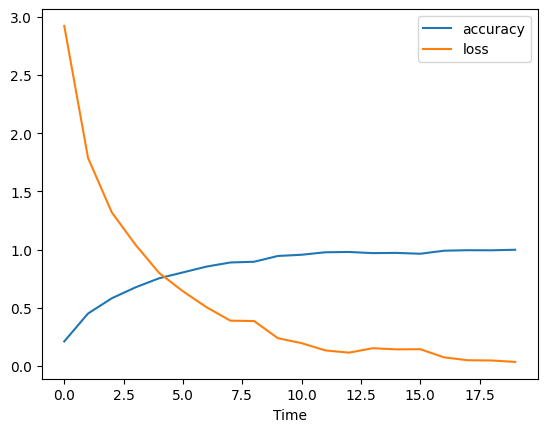

In [ ]:
plt.plot(history_ResNet.history['accuracy'])
plt.plot(history_ResNet.history['loss'])
plt.xlabel('Time')
plt.legend(['accuracy', 'loss'])
plt.show()

In [ ]:
def predict_image(image_path, model):
    img = image.load_img(image_path, target_size=(224,224,3))
    plt.imshow(img)
    plt.show()
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    images = np.vstack([x])
    pred = model.predict(images, batch_size=32)
    file_name = image_path.name
    actual = file_name.split("_")[0]
    print("Actual: " + actual)
    print("Predicted: "+classes[np.argmax(pred)])


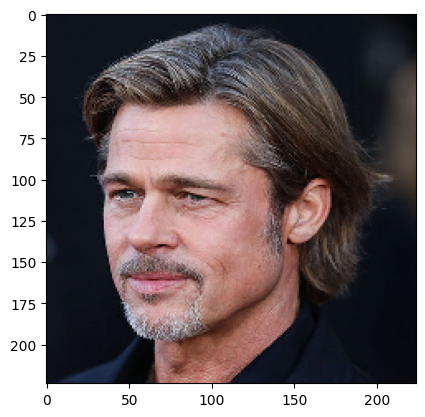

1/1 [==============================] - 0s 193ms/step
Actual: Brad Pitt
Predicted: Roger Federer


In [ ]:
from pathlib import Path
pred_path  = Path("../input/face-recognition-dataset/Original Images/Original Images/")
predict_image(pred_path/"Brad Pitt/Brad Pitt_102.jpg", model_resnet)

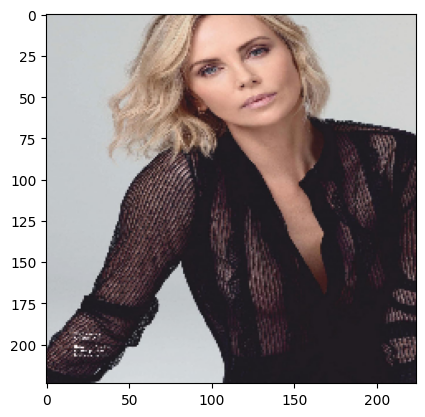

1/1 [==============================] - 0s 177ms/step
Actual: Charlize Theron
Predicted: Andy Samberg


In [ ]:
predict_image(pred_path/"Charlize Theron/Charlize Theron_26.jpg", model_resnet)


# Resnet Validation

In [ ]:
datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True, validation_split = 0.2)
data_dir = "../input/face-recognition-dataset/Original Images/Original Images/"

train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=32,
    subset='training',
    shuffle = True)
val_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=32,
    subset='validation',
    shuffle = True)


Found 2060 images belonging to 31 classes.
Found 502 images belonging to 31 classes.


In [ ]:
# ResNet
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization
import numpy as np
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout
import matplotlib.pyplot as plt
from tensorflow.keras.layers  import BatchNormalization
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

classes = list(train_generator.class_indices.keys())
base_model  = ResNet50(include_top=False, input_shape=(224, 224, 3), pooling='avg')
model_resnet = Sequential([
    base_model,
    Flatten(),
    Dense(1024, activation = "relu"),
    Dropout(0.2),
    Dense(len(classes), activation = "softmax")
])

In [ ]:
model_resnet.compile(
    loss= "categorical_crossentropy",
    optimizer = Adam(),
    metrics = ["accuracy"]
)
model_resnet.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 1024)              2098176   
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                                 
 dense_3 (Dense)             (None, 31)                31775     
                                                                 
Total params: 25717663 (98.11 MB)
Trainable params: 25664543 (97.90 MB)
Non-trainable params: 53120 (207.50 KB)
_________________________________________________________________


In [ ]:
history_ResNet = model_resnet.fit(train_generator,epochs= 20, batch_size=32, validation_data=val_generator)

Epoch 1/20
65/65 [==============================] - ETA: 0s - loss: 2.9359 - accuracy: 0.1699 

KeyboardInterrupt: 

In [ ]:
plt.plot(history_ResNet.history['accuracy'])
plt.plot(history_ResNet.history['val_accuracy'])
plt.xlabel('epochs')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

# 4. CNN Part


In [ ]:
# CNN
datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True, validation_split = 0.2)
data_dir = "../input/face-recognition-dataset/Original Images/Original Images/"

train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=32,
    subset='training',
    shuffle = True)
val_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=32,
    subset='validation',
    shuffle = True)

classes = list(train_generator.class_indices.keys())
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),
    Conv2D(96, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),
    Dropout(0.2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(len(classes),activation='softmax')
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Found 2060 images belonging to 31 classes.
Found 502 images belonging to 31 classes.
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 111, 111, 32)      128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                              

In [ ]:
history_CNN = model.fit(train_generator,epochs=100, batch_size=32, validation_data=val_generator)

Epoch 1/100
65/65 [==============================] - 269s 4s/step - loss: 3.5703 - accuracy: 0.0714 - val_loss: 3.4963 - val_accuracy: 0.0438
Epoch 2/100
65/65 [==============================] - 268s 4s/step - loss: 2.9943 - accuracy: 0.1646 - val_loss: 4.2063 - val_accuracy: 0.0398
Epoch 3/100
65/65 [==============================] - 264s 4s/step - loss: 2.7263 - accuracy: 0.2068 - val_loss: 4.0225 - val_accuracy: 0.0498
Epoch 4/100
65/65 [==============================] - 270s 4s/step - loss: 2.4588 - accuracy: 0.2806 - val_loss: 4.5576 - val_accuracy: 0.0319
Epoch 5/100
65/65 [==============================] - 264s 4s/step - loss: 2.2214 - accuracy: 0.3393 - val_loss: 3.5240 - val_accuracy: 0.0857
Epoch 6/100
65/65 [==============================] - 263s 4s/step - loss: 2.0565 - accuracy: 0.3743 - val_loss: 3.3254 - val_accuracy: 0.1414
Epoch 7/100
65/65 [==============================] - 263s 4s/step - loss: 1.8711 - accuracy: 0.4286 - val_loss: 2.9287 - val_accuracy: 0.2072
Epoch 

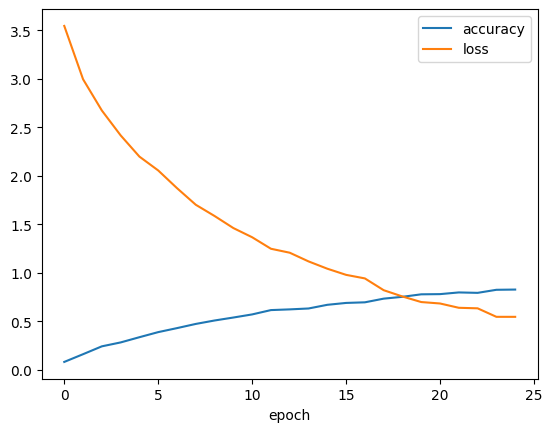

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history_CNN.history['accuracy'])
plt.plot(history_CNN.history['loss'])
plt.xlabel('epoch')
plt.legend(['accuracy', 'loss'])
plt.show()

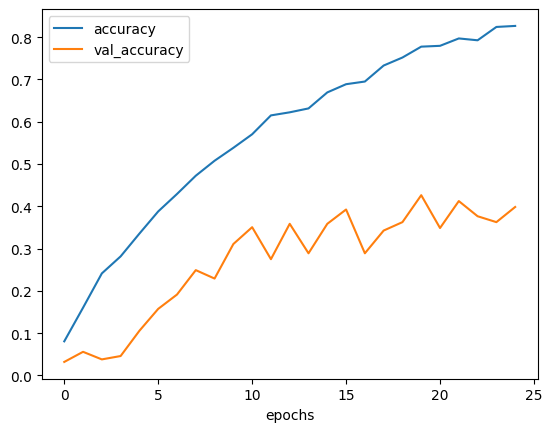

In [ ]:
plt.plot(history_CNN.history['accuracy'])
plt.plot(history_CNN.history['val_accuracy'])
plt.xlabel('epochs')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

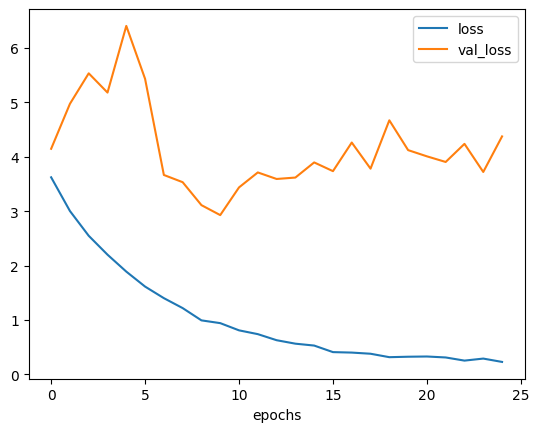

In [ ]:
plt.plot(history_CNN.history['loss'])
plt.plot(history_CNN.history['val_loss'])
plt.xlabel('epochs')
plt.legend(['loss', 'val_loss'])
plt.show()